## Demo for GW Signal Injection 
This demonstration provides examples for the injection of GW signals. 
The waveforms of GWs may be input from analytical expressions, external codes, time series data, and SGWB spectra.
The simulations in this demo do not include noises, and noisy data can be generated by turning on the switch of noises in the simulator. 
Most GW signals can be injected through the following steps to ultimately generate their TDI responses.

<img src="../Figures/GWInjection.png" alt="Drawing" style="width: 1000px;" align="center">

It should be noticed that Triangle is designed as a prototype simulator for the data of space-based GW detectors, aiming to illustrate the characteristics of data (especially the noises) as faithfully as possible, while maintaining a high degree of flexibility. 
On the other hand, the speed of GW response simulation may not meet the requirements of other research, such as running MCMC. 
For these needs, users may turn to more specialized tools that can generate fast GW responses (such as FastLISAResponse, BBHx, etc), 
and we have confirmed that in the sense of GW response calculation, the differences between Triangle and FastLISAResponse is well below the level of instrumental noises.


In [1]:
# limit the thread used by numpy for better parallelization 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  
os.environ["MKL_NUM_THREADS"] = "1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import healpy as hlp 

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Offset import *
from Triangle.Plot import *
from Triangle.Data import *
from Triangle.GW import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Cosmology import *

# or just
# from Triangle import *

# Uncomment this if LaTeX is installed for better visualization
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


## Set multiprocessing 

In [3]:
import multiprocessing
print('number of cpus =', multiprocessing.cpu_count())
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
# pool = None 

number of cpus = 12


## 1. Simulate GB signal 

### 1.1 data and instrument model settings 

In [4]:
fsample = 0.1 # use a lower sampling rate for signal-only simulations 
data_time = 110 * DAY 
size = int(data_time * fsample)
interp_order = 11 # use a lower interpolation order for signal-only simulations 

orbit = Orbit(OrbitDir='../OrbitData/MicroSateOrbitEclipticTCB') 
offset = OffsetFunctions(laser_flag=False, clock_flag=False) 
noise = InstrumentalPSDs(L=L_nominal) 

### 1.2 Initialize GB waveform and single-arm response 
#### 1.2.1 GB waveform 
The "unprojected" GW waveforms (the raw GW polarizations which are not responsed by detectors) can be initialized by a ``GWwaveform`` object, which must contain 2 functions ``hpfunc`` and ``hcfunc`` that return $h_+(t)$ and $h_\times(t)$ at given array of time. 

For example, for a Galactic binary system with circular orbit, the unprojected waveforms are: 
$$h_+(t) = A (1 + \cos^2 \iota) \cos \left[ \varphi \left(t\right) \right], \quad h_\times(t) = 2A \cos \iota \sin \left[ \varphi \left(t\right) \right]$$
where the phase of GW takes a Taylor expansion form: $\varphi(t) = 2\pi\left(f_0 t + \frac{1}{2}\dot{f}_0 t^2 + \frac{1}{6} \ddot{f}_0 t^3\right) + \varphi_0$.
#### 1.2.2 single-arm response
The simulator uses ``GW`` object (or a list of "GW" classes) to calculate the single-arm responses of GWs. 

Each ``GW`` object represents a GW signal, which should be initialized by:
- GWwaveform: a ``GWwaveform`` object;
- orbit: an ``Orbit`` object;
- ext_params: a list of 3 extrinsic parameters: [ecliptic longitude $\lambda$, ecliptic latitude $\beta$, polarization angle $\psi$].

The single-arm response can be represented by the doppler shift of laser frequency as:
$$s_{c, ij} \approx \nu_0 y_{ij}$$
where $\nu_0$ (usually set to 281.6 THz) is the central frequency of laser, and the fractional frequency difference reads [Ref: [JCAP04(2023)066](https://iopscience.iop.org/article/10.1088/1475-7516/2023/04/066)]
$$y_{ij}(t)
    = \frac{1}{2\left(1-\bm{\hat{k}} \cdot \bm{\hat{n}}_{ij}(t_i)\right)}\left[H_{ij}\left(t - \frac{d_{ij}(t)}{c} - \frac{\bm{\hat{k}} \cdot \bm{R}_j(t)}{c}\right) 
    -  H_{ij}\left(t - \frac{\bm{\hat{k}} \cdot \bm{R}_i(t)}{c}\right)\right]$$
with 
$$H_{ij} \equiv \bm{h} : \bm{\hat{n}}_{ij} \otimes \bm{\hat{n}}_{ij}$$

One may notice that the single-arm response $y_{ij}$ can be calculated by the ``GW`` object itself. 
While to conduct a more complete simulation, especially considering the conversion of time frames, we further input ``GW`` into the whole ``Triangle.Interferometor`` simulator. 
This would inevitably make the calculation much slower. 

In [5]:
gb = GB(
    A=1.39879192e-22, 
    f=0.00984299, 
    fdot=4.31168731e-16, 
    iota=2.29680093, 
    phi0=0.79960729
    ) # this is a GWwaveform object 

# set 3 extrinsic parameters 
lam = 4.50950561
beta = -0.30076513
psi = 3.08152927
# initialize single-arm response 
gw = [GW(GWwaveform=gb, orbit=orbit, ext_params=[lam, beta, psi]), ]

# GB.hpfunc, GB.hcfunc

### 1.3 Simulate interferomertric data 

#### simulate interferometric data 

In [6]:
ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ProperTime',
    acc_noise=False,
    ro_noise=False,
    laser_noise=False,
    clock_noise=False, 
    ob_noise=False, 
    bl_noise=False,
    op_noise=False, 
    ranging_noise=False, 
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=gw, 
    fplan=None, # the final TDI responses of GWs will not change with the settings of locking scheme and frequency plan, thus we set fplan=None without losing generality.
    order=interp_order,
    pool=pool,
    clean_memory=True,
    )

ifo.SimulateInterferometers()
m = ifo.OutputMeasurements(mode='decomposed') 
ifo.clean()

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) 
m1.keys()

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b'])

### 1.4 TDI combination 
GW signal is unchanged during the first 2 steps of TDI, i.e. for a GW-only data, 
$$\eta_{ij} = \xi_{ij} = s_{c, ij}$$
Therefore the TDI combination of $\eta_{ij}$ is actually the combination of $y_{ij}$. For example, the 2nd-generation Michelson X channel reads 
$$X_2 = \left(1 - \bm{\rm D}_{131} - \bm{\rm D}_{13121} + \bm{\rm D}_{1213131}\right) \left(\eta_{12}+\bm{\rm D}_{12}\eta_{21}\right)
 - \left(1 - \bm{\rm D}_{121} - \bm{\rm D}_{12131} + \bm{\rm D}_{1312121}\right) \left(\eta_{13}+\bm{\rm D}_{13}\eta_{31}\right) $$
The expressions for Y, Z channels can be obtained by the permutation rule: $1 \rightarrow 2, 2 \rightarrow 3, 3 \rightarrow 1$. The semi-orthorgonal A, E, T channels are defined as the combinations of "basic" TDI channels: 
$$A_2 \equiv \frac{Z_2 - X_2}{\sqrt{2}}, \quad E_2 \equiv \frac{X_2 - 2 Y_2 + Z_2}{\sqrt{6}}, \quad T_2 \equiv \frac{X_2 + Y_2 + Z_2}{\sqrt{3}}$$

In [7]:
tdi = TDI(measurements=m1, delays=m1['ltt'], fsample=m1['fsample'], order=interp_order)
tdi.CalculateXi(doppler=True, pool=pool) 
tdi.CalculateEta(doppler=True)
tdi.FastMichelson(doppler=True, channel='AET')

tdi.measurements.keys()

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X0', 'X1', 'X2', 'Y0', 'Y1', 'Y2', 'Z0', 'Z1', 'Z2', 'A0', 'E0', 'T0', 'A1', 'E1', 'T1', 'A2', 'E2', 'T2'])

#### plot TDI responses (in the fractional frequency difference unit)
By default the raw interferometry data is in frequency unit. Here we convert the data to the fractional frequency difference unit, which is more frequently used in GW data analysis. 
$${\rm fractional \ freqneucy \ difference} = \frac{\rm frequency}{\nu_0}$$
One may notice that data at the beginning are invalid due to interpolation. 

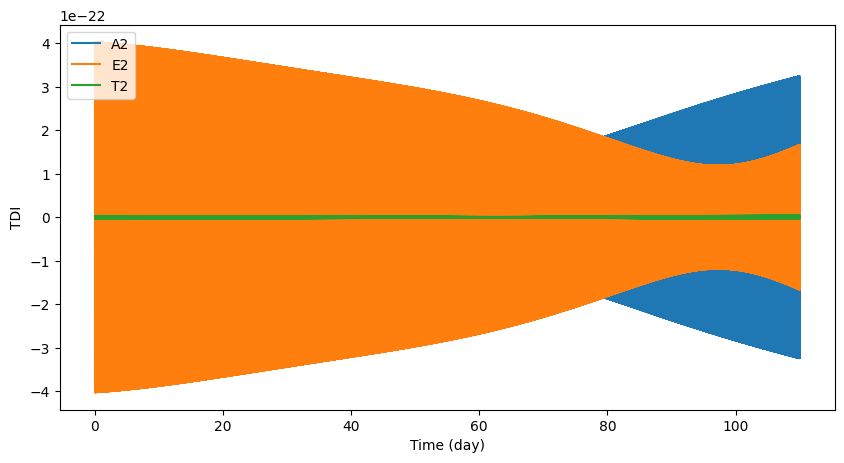

In [8]:
drop_points = int(1000 * fsample)

plt.figure(figsize=(10, 5))
for channel_name in ['A2', 'E2', 'T2']:
    plt.plot(tdi.measurements['time']['1'][drop_points:-drop_points] / DAY, tdi.measurements[channel_name][drop_points:-drop_points] / F_LASER, label=channel_name)
plt.xlabel('Time (day)')
plt.ylabel('TDI')
plt.legend(loc="upper left")

## 2. Simulate MBHB signal using the EOB waveform of PyCBC
We showcase that external codes such as ``PyCBC`` can be used as the input of our simulator. 
Note that we only use ``PyCBC`` as a representative example for the various GW waveform generators, and it is not a necessary dependency of ``Triangle``. 
Moreover, neither ``SEOBNRv4_opt`` nor our simple wrapper of this approximant should be regarded as an accurate template for space-based GW detections. 

### 2.1 data and instrument model settings 

In [9]:
fsample = 0.1
data_time = 10 * DAY 
size = int(data_time * fsample)
interp_order = 11

orbit = Orbit(OrbitDir='../OrbitData/MicroSateOrbitEclipticTCB') 
offset = OffsetFunctions(laser_flag=False, clock_flag=False) 
noise = InstrumentalPSDs(L=L_nominal) 

### 2.2 Initialize MBHB waveform and single-arm response 

In [10]:
# set parameters 
Mc = 400000.0 # redshifted chirp mass in solar mass 
q = 0.3640815267051051 # mass ratio m2 / m1
spin1z = 0.7899406190510447 # spin of BH1
spin2z = 0.015424596359292053 # spin of BH2 
tc = 5. * DAY # coalescence time in second 
phic = 3.2535342675592966 # coalescence phase in rad 
D = 106039.10941463517 # luminosity distance in MPC 
inc = 1.4495086550199021 # inclination angle 

# set waveform template 
approx = 'SEOBNRv4_opt'

# initialize MBHB waveform
mbhb = MBHB(approx_method=approx)
mbhb(Mc=Mc, q=q, spin1z=spin1z, spin2z=spin2z, tc=tc, phic=phic, D=D, inc=inc)

# set 3 extrinsic parameters 
lam = 3.032776598141215
beta = -1.1817968279048852
psi = 0.2409146690555858

# initialize single-arm response 
gw = [GW(GWwaveform=mbhb, orbit=orbit, ext_params=[lam, beta, psi]),] 

### 2.3 Simulate interferometry data 

#### generate interferometric data 

In [11]:
ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ProperTime',
    acc_noise=False, 
    ro_noise=False,
    laser_noise=False,
    clock_noise=False, 
    ob_noise=False, 
    bl_noise=False,
    op_noise=False, 
    ranging_noise=False, 
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=gw, 
    fplan=None,
    order=interp_order,
    pool=pool,
    clean_memory=True,
    )

ifo.SimulateInterferometers()
m = ifo.OutputMeasurements(mode='decomposed') 
ifo.clean()

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) 
m1.keys()

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b'])

### 2.4 TDI combination 

In [12]:
tdi = TDI(measurements=m1, delays=m1['ltt'], fsample=m1['fsample'], order=interp_order)
tdi.CalculateXi(doppler=True, pool=pool)  
tdi.CalculateEta(doppler=True)
tdi.FastMichelson(doppler=True, channel='AET')

tdi.measurements.keys()

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X0', 'X1', 'X2', 'Y0', 'Y1', 'Y2', 'Z0', 'Z1', 'Z2', 'A0', 'E0', 'T0', 'A1', 'E1', 'T1', 'A2', 'E2', 'T2'])

#### plot TDI responses (in the fractional frequency difference unit)

Text(0, 0.5, 'TDI')

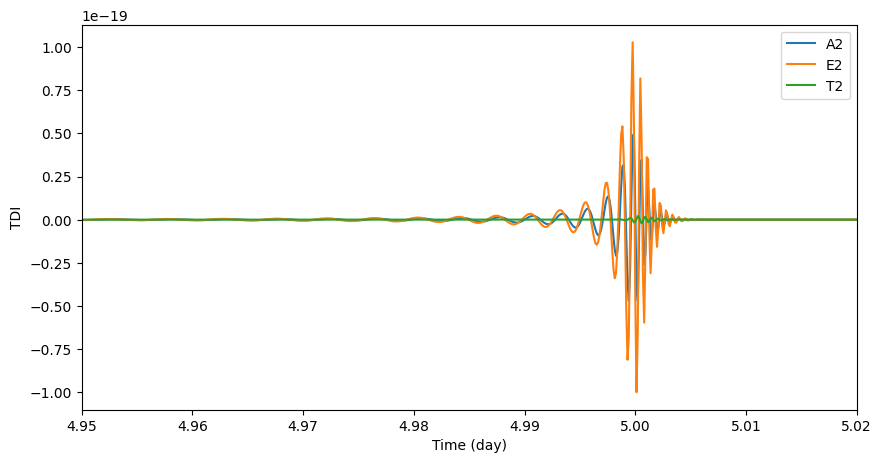

In [13]:
drop_points = int(1000 * fsample)

plt.figure(figsize=(10, 5))
for channel_name in ['A2', 'E2', 'T2']: 
    plt.plot(tdi.measurements['time']['1'][drop_points:-drop_points]/DAY, tdi.measurements[channel_name][drop_points:-drop_points]/F_LASER, label=channel_name)

plt.xlim(5 - 0.05, 5 + 0.02)
plt.legend()
plt.xlabel('Time (day)')
plt.ylabel('TDI')

## 3. Simulate arbitrary signal from waveform data

### 3.1 data and instrument model settings 

In [14]:
fsample = 0.1
data_time = 10 * DAY 
size = int(data_time * fsample)
interp_order = 11

orbit = Orbit(OrbitDir='../OrbitData/MicroSateOrbitEclipticTCB') 
offset = OffsetFunctions(laser_flag=False, clock_flag=False) 
noise = InstrumentalPSDs(L=L_nominal) 

### 3.2 create a wrapper for the waveform data and initialize single-arm response 
As before, the waveform wrapper class must contain two functions: 
- hpfunc: $h_+(t)$
- hcfunc: $h_\times(t)$

For example, we use spline interpolation to create a simple wrapper:

In [15]:
waveform_data = np.load("../GWData/Demo_EMRI_waveform_data.npz")
tdata, hpdata, hcdata = waveform_data["t"], waveform_data["h1"], -waveform_data["h2"] # since h2 is -hx

waveform_wrapper = GeneralWaveform(tdata, hpdata, hcdata)

# randomize 3 extrinsic parameters 
lam = np.random.uniform(0, TWOPI) 
beta = np.arcsin(np.random.uniform(-1, 1))
psi = np.random.uniform(0, PI)

# initialize GW object 
gw = [GW(GWwaveform=waveform_wrapper, orbit=orbit, ext_params=[lam, beta, psi]),] 

### 3.3 simulate interferometric data and TDI combination 

In [16]:
ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ProperTime',
    acc_noise=False, 
    ro_noise=False,
    laser_noise=False,
    clock_noise=False, 
    ob_noise=False, 
    bl_noise=False,
    op_noise=False, 
    ranging_noise=False, 
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=gw, 
    fplan=None,
    order=interp_order,
    pool=pool,
    clean_memory=True,
    )

ifo.SimulateInterferometers()
m = ifo.OutputMeasurements(mode='decomposed') 
ifo.clean()

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) 

tdi = TDI(measurements=m1, delays=m1['ltt'], fsample=m1['fsample'], order=interp_order)
tdi.CalculateXi(doppler=True, pool=pool) 
tdi.CalculateEta(doppler=True)
tdi.FastMichelson(doppler=True, channel='AET')

tdi.measurements.keys()

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X0', 'X1', 'X2', 'Y0', 'Y1', 'Y2', 'Z0', 'Z1', 'Z2', 'A0', 'E0', 'T0', 'A1', 'E1', 'T1', 'A2', 'E2', 'T2'])

Text(0, 0.5, 'TDI')

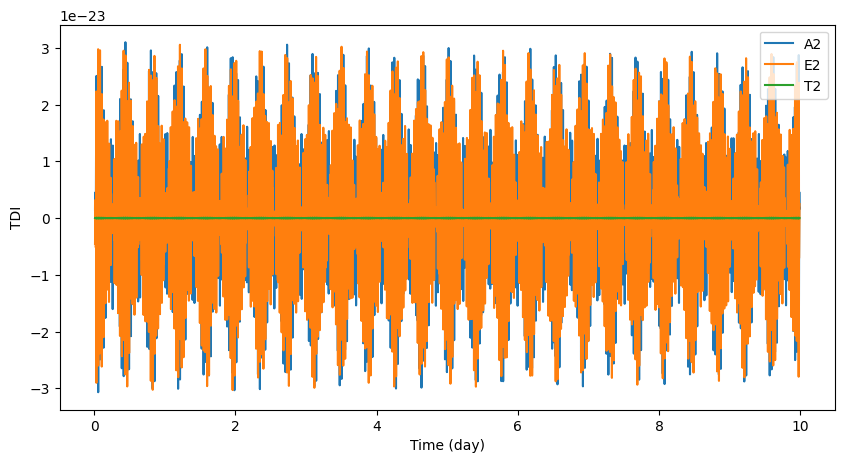

In [17]:
drop_points = int(1000 * fsample)

plt.figure(figsize=(10, 5))

for channel_name in ['A2', 'E2', 'T2']: 
    plt.plot(tdi.measurements['time']['1'][drop_points:-drop_points]/DAY, tdi.measurements[channel_name][drop_points:-drop_points]/F_LASER, label=channel_name)
plt.legend()
plt.xlabel('Time (day)')
plt.ylabel('TDI')

In ``Triangle.GW``, there is also a function ``Initial_GW_response`` which can be used to initialize the responses of MBHBs, GBs and other general waveforms in a more compact manner.  

Instructions on the usage of ``Initial_GW_response``: 

Initialize_GW_response(parameters, signal_type="MBHB", orbit=None, approximant=None, data=None):    

Args:   
    - signal_type: 'MBHB', 'GB', 'general'.   
    - parameters: a dictionary storing the parameters of signal. Each item can be either a float number or a numpy array.  
    1) For MBHB, the keys are 'chirp_mass' (in solar mass), 'mass_ratio', 'spin_1z', 'spin_2z', 'coalescence_time' (in day), 'coalescence_phase', 'luminosity_distance' (in MPC), 'inclination', 'longitude', 'latitude', 'polarization';   
    2) for GB, the keys are 'A', 'f0', 'fdot0', 'phase0', 'inclination', 'longitude', 'latitude', 'psi';     
    3) for general GW, the keys are "longitude", "latitude", "polarization" (only extrinsic parameters).     
    - orbit should be an "Orbit" object.      
    - approximant is only required for MBHB.      
    - data is only required for general, data = [[tdata, hpdata, hcdata], [tdata, hpdata, hcdata], ], tdata in second unit. 

Returns:   
    a list of GW objects, which can be passed to Interferometer(). 

Usage:    
    gw_response_generator = Initialize_GW_response(...)   
    ifo = Interferometer(   
        ...    
        gw = gw_response_generator,    
        ...   
    )   

See the next tutorial for example. 

## 4. Simulate SGWB 
SGWB is simulated as the superposition of numerous stochastic signals. 
This approach is better than simulating from the spectrum of TDI response in the sense that it incorporates the influence of armlength variations. 

We use the relationship between GW power spectrum and GW fractional density: 
$$S_{\rm GW}(f) = \frac{3H_0^2}{4\pi^2 f^3}\Omega_{\rm GW}$$

The directions of incident GW signals are generated by the rule of HEALPIX. For an isotropic SGWB, in each direction 
$$S_{\rm GW}(f, \bm{\hat{n}}_k) = \frac{S_{\rm GW}(f)}{N_{\rm pix}}$$ 
$\bm{\hat{n}}_k$ being the unit vector pointing to the center of a certain pixel with index $i$,  ($i \in \{1, N_{\rm pix}\}$).
We then randomly draw the signals $h_+(t, \bm{\hat{n}}_k), h_\times(t, \bm{\hat{n}}_k)$ from $S_{\rm GW}(f, \bm{\hat{n}}_k)$ in all directions. 
Then the incident GW signals are responded by arms according to extrinsic parameters $\{\lambda_i, \beta_i, \psi=0\}$ (since $\psi$ is absorbed into $h_{+ / \times}$). The total single-arm responses read
$$y_{ij}(t) = \sum_{k=1}^{N_{\rm pix}} y_{ij}(t, \bm{\hat{n}}_k)$$

In this tutorial we take as an example the following SGWB model: 
$$\Omega_{\rm GW}(f) = \Omega_0 \left(\frac{f}{f_0}\right)^n$$

To verify the result, we use the theoretical PSD of $X_2$ channel: 
$$S_{X_2}(f) = \mathcal{R}_{X_2}(f) S_{\rm SGWB}(f)$$
In the low-frequency, equal-arm limit, the average response of $X_2$ reads 
$$\mathcal{R}_{X_2}(f) \approx \frac{96}{5} u^2 \sin^2(u) \sin^2(2u) \cos^2\left(\frac{u}{2}\right)$$
where $u \equiv 2\pi f L/c$, $L$ being the nominal armlength of detector.

### 4.1 Initialize unprojected polarizations 

In [18]:
fsample = 0.1 
data_time = 15 * DAY 
size = int(data_time * fsample)
interp_order = 11

offset = OffsetFunctions(laser_flag=False, clock_flag=False) 
noise = InstrumentalPSDs(L=L_nominal) 
orbit = Orbit(OrbitDir='../OrbitData/MicroSateOrbitEclipticTCB') 

In [19]:
# define the SGWB fractional density 
def Omega_SGWB(f, Omega0, f0, n): 
    return Omega0 * (f / f0) ** n 

# define the PSD of polarizations 
def S_SGWB(f, Omega0=1e-11, f0=3.162e-3, n=-1.): 
    Omega = Omega_SGWB(f, Omega0, f0, n)
    return 3. * H0 ** 2 / 4. / np.pi ** 2 / f ** 3 * Omega * 1e6 / MPC ** 2 

# get the sky locations 
NSIDE = 5
NPIX = hlp.nside2npix(NSIDE)
print("number of directions:", NPIX)
colatitude, longitude = hlp.pix2ang(nside=NSIDE, ipix=np.arange(NPIX))
latitude = np.pi / 2. - colatitude

# generate stochastic signals in all the directions 
sgwb_generator = GeneralNoise(S_SGWB)
tdata = np.arange(size) / fsample
gw = [] 
for i in tqdm(range(NPIX)): 
    hp_k = sgwb_generator(fsample=fsample, size=size) / np.sqrt(NPIX)
    hc_k = sgwb_generator(fsample=fsample, size=size) / np.sqrt(NPIX)
    Waveform_k = GeneralWaveform(tdata=tdata, hpdata=hp_k, hcdata=hc_k)
    GW_k = GW(orbit=orbit, ext_params=[longitude[i], latitude[i], 0.], GWwaveform=Waveform_k) # here we set psi=0 since it is absorbed to h+ and hx
    gw.append(GW_k)

number of directions: 300


100%|██████████| 300/300 [00:10<00:00, 28.16it/s]


### 4.2 Calculate the total single-arm response 

In [20]:
ifo = Interferometers(
    size=size,
    fsample=fsample,
    time_frame='ProperTime',
    acc_noise=False, 
    ro_noise=False,
    laser_noise=False,
    clock_noise=False, 
    ob_noise=False, 
    bl_noise=False,
    op_noise=False, 
    ranging_noise=False, 
    modulation_noise=False,
    orbit_class=orbit,
    offset_class=offset,
    noise_class=noise,
    gw_class=gw, 
    fplan=None,
    order=interp_order,
    pool=pool,
    clean_memory=True,
    )

ifo.SimulateInterferometers()
m = ifo.OutputMeasurements(mode='decomposed') 
ifo.clean()

m1 = TPStoTCB(m, orbit_class=orbit, order=interp_order, pool=pool) 

### 4.3 TDI combination 

In [21]:
tdi = TDI(measurements=m1, delays=m1['ltt'], fsample=m1['fsample'], order=interp_order)
tdi.CalculateXi(doppler=True, pool=pool) 
tdi.CalculateEta(doppler=True)
tdi.FastMichelson(doppler=True, channel='XYZ')

tdi.measurements.keys()

dict_keys(['time', 'fsample', 'ltt', 'sci_c', 'sci_sb', 'ref_c', 'ref_sb', 'tm_c', 'a', 'b', 'dpl', 'xi', 'eta', 'X0', 'X1', 'X2', 'Y0', 'Y1', 'Y2', 'Z0', 'Z1', 'Z2'])

Text(0, 0.5, '${\\rm ASD \\ (Hz^{-1/2})}$')

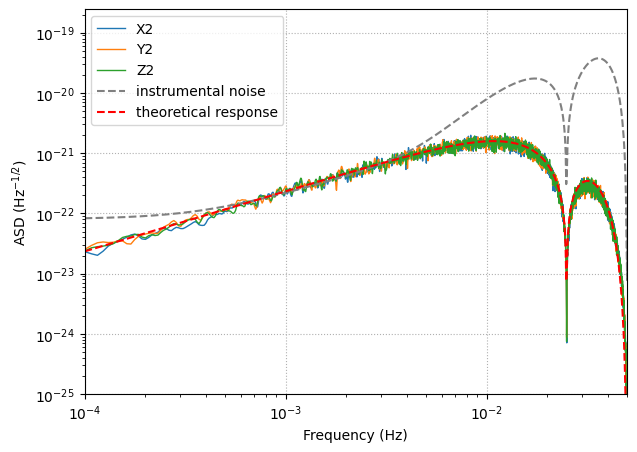

In [22]:
plt.figure(figsize=(7, 5))

drop_points = int(1000 * fsample)

for channel_name in ["X2", "Y2", "Z2"]:
    ff, xf = PSD_window(tdi.measurements[channel_name][drop_points:-drop_points]/F_LASER, fsample, nbin=10, window_type="kaiser", window_args_dict=dict(beta=28))
    plt.loglog(ff, np.sqrt(xf), linewidth=1, label=channel_name) 


plot_freqs = np.logspace(-4, -1, 1000)
PSDFunction = TDIPSDs()
plt.loglog(plot_freqs, np.sqrt(PSDFunction.PSD_X2(plot_freqs)), linestyle="--", color='grey', label="instrumental noise") # instrumental noise PSD in the equal-arm limit

plot_u = TWOPI * plot_freqs * L_nominal / C 
ResFunction = 96. / 5. * plot_u ** 2 * np.sin(plot_u) ** 2 * np.sin(2. * plot_u) ** 2 * np.cos(plot_u / 2.) ** 2 # average X2 response function in the equal-arm, long-wavelength limits
plt.loglog(plot_freqs, np.sqrt(ResFunction * S_SGWB(plot_freqs)), linestyle="--", color='red', label="theoretical response")

plt.grid(linestyle=":")
plt.legend(loc="upper left")
plt.ylim(1e-25, )
plt.xlim(1e-4, 0.05)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"${\rm ASD \ (Hz^{-1/2})}$")

## 5. Sensitivity analysis 

Sensitivity analysis is usually the 1st step of GW data analysis. 
By drawing the signal against the sensitivity of a detector, one may have a rough assessment of the detectability of the signal. 
In the context of space-based GW detection, sensitivity is closely related to the configuration of detector constellation, as well as the choice of TDI combination scheme. 
We calculate the sensitivity of a space-based GW detector following the definition of [Class. Quantum Grav. 36 105011](https://iopscience.iop.org/article/10.1088/1361-6382/ab1101):
$$S_X(f) \equiv \frac{P_X(f)}{\langle \mathcal{R}_X(f) \rangle_{\lambda, \beta, \psi}}$$
with $X$ representing any TDI channel, and P_X(f) the PSD of noises after TDI processing. The response function $\mathcal{R}_X(f)$ is defined as
$$|\tilde{X}(f)|^2 = \mathcal{R} \left( |\tilde{h}_+(f)|^2 + |\tilde{h}_\times(f)|^2 \right)$$
and $\langle \cdot \rangle_{\lambda, \beta, \psi}$ denotes averaging over the sources' angular coordinates and polarization angles. 

In realistic data analysis, the definition of "noise" could be rather tricky. Here we make an idealistic assumption that $P_X(f)$ includes only the contribution of two instrumental noises, i.e. the optical metrology noise and test-mass acceleration noise. The following definitions apply to any TDI channel and any orbit configurations. 

### 5.1 Set TDI scheme with the $P_{ij}$ strings

In [23]:
X2_strings = {
    "12": [(-1., []), (1., ["13", "31"]), (1., ["13", "31", "12", "21"]), (-1., ["12", "21", "13", "31", "13", "31"])], 
    "23": [], 
    "31": [(1., ["13"]), (-1., ["12", "21", "13"]), (-1., ["12", "21", "13", "31", "13"]), (1., ["13", "31", "12", "21", "12", "21", "13"])], 
    "21": [(-1., ["12"]), (1., ["13", "31", "12"]), (1., ["13", "31", "12", "21", "12"]), (-1., ["12", "21", "13", "31", "13", "31", "12"])], 
    "32": [], 
    "13": [(1., []), (-1., ["12", "21"]), (-1., ["12", "21", "13", "31"]), (1., ["13", "31", "12", "21", "12", "21"])], 
}

### 5.2 Set the configuration of orbit 
Generally, both the TDI response of signal and the TDI combination of noises are affected by the armlengths. As an example, we set the states of orbit according to our numerical orbit at a random time. 

In [24]:
orbit = Orbit(OrbitDir='../OrbitData/MicroSateOrbitEclipticTCB') 

orbit_time = np.random.uniform(0, 100*DAY)

Ri_test = dict()
for key in SC_labels: 
    Ri_test[key] = orbit.Positionfunctions()[key](orbit_time)

nij_test = dict()
dij_test = dict() 
for key in MOSA_labels: 
    nij_test[key] = orbit.ArmVectorfunctions()[key](orbit_time)
    dij_test[key] = orbit.LTTfunctions()[key](orbit_time)

Ri_test, nij_test, dij_test 


({'1': array([-1.30562697e+11,  7.18572958e+10,  4.49982793e+08]),
  '2': array([-1.32198699e+11,  6.94222996e+10,  9.85160045e+08]),
  '3': array([-1.30509235e+11,  6.95655377e+10, -1.48324038e+09])},
 {'12': array([ 0.54866075,  0.81655212, -0.17948263]),
  '13': array([-0.01783432,  0.76421394,  0.64471621]),
  '23': array([-0.56416655, -0.04790368,  0.82427019]),
  '21': array([-0.54860402, -0.8165956 ,  0.17945821]),
  '31': array([ 0.01782154, -0.7642723 , -0.64464739]),
  '32': array([ 0.56416307,  0.04776033, -0.82428089])},
 {'12': array(9.94616385),
  '13': array(10.00211984),
  '23': array(9.98906444),
  '21': array(9.94737507),
  '31': array(10.00323574),
  '32': array(9.98895191)})

### 5.3 Calculate and plot sensitivity 
to convert to the dimensionless characteristic strain, one needs to further multiply $S(f)$ by $f$. 

100%|██████████| 1024/1024 [00:00<00:00, 4361.59it/s]


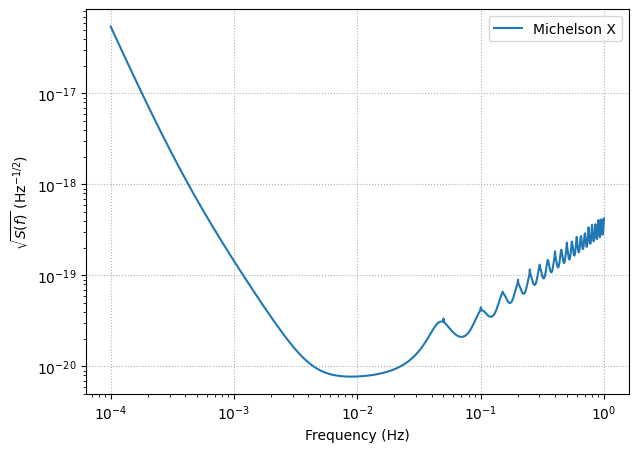

In [25]:
plt.figure(figsize=(7, 5))

sensitivity = TDISensitivity(Ri=Ri_test, nij=nij_test, dij=dij_test)

plot_freqs = np.logspace(-4, 0, 1000)
plot_sens_X = sensitivity.TDI_sensitivity(f=plot_freqs, P_ij_strings=X2_strings, Nsource=1024)
plt.loglog(plot_freqs, np.sqrt(plot_sens_X), label='Michelson X')

plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\sqrt{S(f)} \ ({\rm Hz^{-1/2}})$")
plt.legend(loc="upper right")
plt.grid(linestyle=":")